In [32]:
# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# For data preprocess
import numpy as np
import csv
import os

# For plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

myseed = 1357  # set a random seed for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

In [33]:
class BatteryDataset(Dataset):
    def __init__(self, path, mode='train', target_only=False):
        self.mode = mode

        with open(path, 'r') as fp:
            data = list(csv.reader(fp))
            data = np.array(data[1:])[:, 1:].astype(float)
        if not target_only:
#             feats = list(range(93))
            feats=list(range(1,5))
        else:
            pass
        if mode == 'test':
            data = data[:, feats]
            self.data = torch.FloatTensor(data)
        else:
            target = data[:, -1]
            data = data[:, feats]

            if mode == 'train':
                indices = [i for i in range(len(data)) if i % 10 != 0]
            elif mode == 'dev':
                indices = [i for i in range(len(data)) if i % 10 == 0]

            self.data = torch.FloatTensor(data[indices])
            self.target = torch.FloatTensor(target[indices])


        self.dim = self.data.shape[1]
        print('Finish reading the {} set of ZF Dataset ({} samples found \
        ,each dim={})'.format(mode, len(self.data), self.dim))

    
    def __getitem__(self,index):
        if self.mode in ['train','dev']:
            return self.data[index],self.target[index]
        else:
            return self.data[index]
    
    def __len__(self):
        return len(self.data)

In [34]:
path=r'F:\study\workreport\dataset\train.csv'
zfdata=BatteryDataset(path,mode='train',target_only=False)

Finish reading the train set of ZF Dataset (736 samples found         ,each dim=4)


In [35]:
def prep_dataloader(path,mode,batch_size,n_jobs=0,target_only=False):
    dataset=BatteryDataset(path,mode=mode,target_only=target_only)
    dataloader=DataLoader(
    dataset,batch_size,
    shuffle=(mode=='train'),drop_last=False,num_workers=n_jobs,pin_memory=True)
    return dataloader

In [36]:
class NeuralNet(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
        )
        self.criterion = nn.MSELoss(reduce='mean')

    def forward(self, x):
        return self.net(x).squeeze(1)

    def cal_loss(self, pred, target):
        return self.criterion(pred, target)

In [37]:
def train(tr_set, dv_set, model, config, device):
    n_epochs = config['n_epochs']
    optimizer = getattr(torch.optim,
                        config['optimizer'])(model.parameters(),
                                             **config['optim_hparas'])

    min_mse = 1000.
    loss_record = {'train': [], 'dev': []}
    early_stop_cnt = 0
    epoch = 0
    while epoch < n_epochs:
        model.train()
        for x, y in tr_set:
            optimizer.zero_grad()
            x, y = x.to(device), y.to(device)
            pred = model(x)
            mse_loss = model.cal_loss(pred, y)
            mse_loss.backward()
            optimizer.step()
            loss_record['train'].append(mse_loss.detach().cpu().item())
        dev_mse = dev(dv_set, model, device)
        if dev_mse < min_mse:
            min_mse = dev_mse
            print('save model (epoch={:4d},,loss={:.4})'.format(
                epoch + 1, min_mse))
            torch.save(model.state_dict(), config['save_path'])
            early_stop_cnt = 0
        else:
            early_stop_cnt += 1

        epoch += 1
        loss_record['dev'].append(dev_mse)
        if early_stop_cnt > config['early_stop']:
            break
    print('finished training after {} epochs'.format(epoch))
    return min_mse, loss_record

In [38]:
def dev(dev_set,model,device):
    model.eval()
    total_loss=0
    for x,y in dv_set:
        x,y =x.to(device),y.to(device)
        with torch.no_grad():
            pred=model(x)
            mse_loss=model.cal_loss(pred,y)
        total_loss +=mse_loss.detach().cpu().item() *len(x)
    total_loss=total_loss / len(dev_set.dataset)
    return total_loss
        

In [39]:
def test(tt_set, model, device):
    model.eval()                                # set model to evalutation mode
    preds = []
    for x in tt_set:                            # iterate through the dataloader
        x = x.to(device)                        # move data to device (cpu/cuda)
        with torch.no_grad():                   # disable gradient calculation
            pred = model(x)                     # forward pass (compute output)
            preds.append(pred.detach().cpu())   # collect prediction
    preds = torch.cat(preds, dim=0).numpy()     # concatenate all predictions and convert to a numpy array
    return preds

In [40]:
os.makedirs(r'F:\study\workreport\dataset\models',
           exist_ok=True)
target_only=False

config={
    'n_epochs':3000,
    'batch_size':64,
    'optimizer':'SGD',
    'optim_hparas':{
        'lr':0.001,
        'momentum': 0.7
    },
    'early_stop':100,
    'save_path':r'F:\study\workreport\dataset\models\model',
}

In [41]:
tr_path=r'F:\study\workreport\dataset\train.csv'
tt_path=r'F:\study\workreport\dataset\test.csv'

In [42]:
tr_set=prep_dataloader(tr_path,'train',config['batch_size'],target_only=target_only)
dv_set=prep_dataloader(tr_path,'dev',config['batch_size'],target_only=target_only)
tt_set=prep_dataloader(tt_path,'test',config['batch_size'],target_only=target_only)

Finish reading the train set of ZF Dataset (736 samples found         ,each dim=4)
Finish reading the dev set of ZF Dataset (82 samples found         ,each dim=4)
Finish reading the test set of ZF Dataset (169 samples found         ,each dim=4)


In [43]:
for i in dv_set:
    print(i)

[tensor([[18.3300, 29.2000,  7.4700, 29.2000],
        [18.7900, 30.8000,  6.7700, 30.8000],
        [18.7900, 29.9000,  7.6700, 29.9000],
        [18.5900, 28.5400,  8.6400, 28.5400],
        [17.9100, 27.1600,  8.6700, 27.1600],
        [17.2500, 28.7000,  5.8000, 28.7000],
        [19.3500, 29.1900,  9.5100, 29.1900],
        [17.6800, 28.5400,  6.8200, 28.5400],
        [19.6800, 31.5000,  7.8700, 31.5000],
        [19.6700, 31.1400,  8.2000, 31.1400],
        [20.9000, 32.3300,  9.4700, 32.3300],
        [19.4600, 30.3400,  8.5700, 30.3400],
        [18.6900, 30.9900,  6.3900, 30.9900],
        [19.9700, 31.7300,  8.2100, 31.7300],
        [19.1400, 30.1100,  8.1600, 30.1100],
        [19.0300, 31.9700,  6.0900, 31.9700],
        [19.6800, 29.6000,  9.7700, 29.6000],
        [21.3500, 33.4300,  9.2700, 33.4300],
        [17.8700, 28.2100,  7.5300, 28.2100],
        [18.5900, 28.1300,  9.0400, 28.1300],
        [18.0000, 28.3900,  7.6100, 28.3900],
        [16.9600, 26.8700,  7.040

In [44]:
model = NeuralNet(tr_set.dataset.dim)

D:\ProgramData\Anaconda3\lib\site-packages\torch\nn\_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [45]:
model_loss, model_loss_record = train(tr_set, dv_set, model, config, 'cpu')

save model (epoch=   1,,loss=0.09937)
save model (epoch=   2,,loss=0.09684)
save model (epoch=   4,,loss=0.09381)
save model (epoch=   5,,loss=0.0928)
save model (epoch=  10,,loss=0.0914)
save model (epoch=  11,,loss=0.08887)
save model (epoch=  13,,loss=0.08566)
save model (epoch=  14,,loss=0.08522)
save model (epoch=  16,,loss=0.08505)
save model (epoch=  17,,loss=0.08291)
save model (epoch=  18,,loss=0.0821)
save model (epoch=  19,,loss=0.0813)
save model (epoch=  21,,loss=0.0806)
save model (epoch=  23,,loss=0.07857)
save model (epoch=  24,,loss=0.07804)
save model (epoch=  26,,loss=0.07683)
save model (epoch=  29,,loss=0.07481)
save model (epoch=  31,,loss=0.07355)
save model (epoch=  33,,loss=0.07323)
save model (epoch=  34,,loss=0.07176)
save model (epoch=  36,,loss=0.07049)
save model (epoch=  39,,loss=0.07041)
save model (epoch=  42,,loss=0.06721)
save model (epoch=  44,,loss=0.06613)
save model (epoch=  45,,loss=0.0657)
save model (epoch=  47,,loss=0.06493)
save model (epoch=

save model (epoch= 749,,loss=4.737e-05)
save model (epoch= 758,,loss=4.707e-05)
save model (epoch= 764,,loss=4.45e-05)
save model (epoch= 765,,loss=4.028e-05)
save model (epoch= 782,,loss=3.274e-05)
save model (epoch= 802,,loss=3.077e-05)
save model (epoch= 814,,loss=2.793e-05)
save model (epoch= 823,,loss=2.741e-05)
save model (epoch= 834,,loss=2.697e-05)
save model (epoch= 839,,loss=2.289e-05)
save model (epoch= 850,,loss=2.249e-05)
save model (epoch= 853,,loss=2.112e-05)
save model (epoch= 855,,loss=2.059e-05)
save model (epoch= 862,,loss=1.902e-05)
save model (epoch= 870,,loss=1.832e-05)
save model (epoch= 880,,loss=1.714e-05)
save model (epoch= 881,,loss=1.652e-05)
save model (epoch= 889,,loss=1.482e-05)
save model (epoch= 902,,loss=1.454e-05)
save model (epoch= 904,,loss=1.446e-05)
save model (epoch= 913,,loss=1.279e-05)
save model (epoch= 929,,loss=1.237e-05)
save model (epoch= 954,,loss=1.01e-05)
save model (epoch= 960,,loss=9.302e-06)
save model (epoch= 971,,loss=8.988e-06)
sa

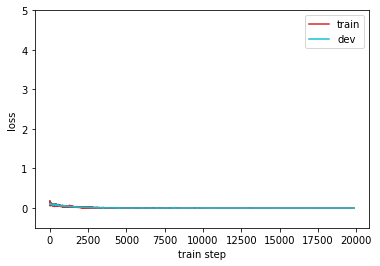

In [46]:
x_1=range(len(model_loss_record['train']))
x_2=x_1[::len(model_loss_record['train']) // len(model_loss_record['dev'])]
plt.plot(x_1,model_loss_record['train'],c='tab:red',label='train')
plt.plot(x_2,model_loss_record['dev'],c='tab:cyan',label='dev')
plt.ylim(-0.5,5.)
# plt.xlim(-0.5,5.)
plt.xlabel('train step')
plt.ylabel('loss')
plt.legend()
plt.show()

In [47]:
def save_pred(preds, file):
    ''' Save predictions to specified file '''
    print('Saving results to {}'.format(file))
    with open(file, 'w') as fp:
        writer = csv.writer(fp)
        writer.writerow(['id', 'tested_positive'])
        for i, p in enumerate(preds):
            writer.writerow([i, p])

In [48]:
preds = test(tt_set, model, 'cpu')  # predict COVID-19 cases with your model
save_pred(preds, r'F:\study\workreport\dataset\pred.csv')  

Saving results to F:\study\workreport\dataset\pred.csv
